# LLM Zoomcamp - Week 3 Notes

In this section the focus is on the following:
- Applying Vector Databases as an alternative to Elasticsearch in the previous two models.
    - Important to note that Elasticsearch has the ability to operate as a Vector DB as an alternative to Lucene and will be covered as well
- Vector embeddings and their role in building RAG applications
- Evaluation methods for search / query retrieval performance

## 3.1 Introduction to Vector Search
- Vector search has been around for a while and is getting popular again largely because LLMs lack long-term memory and have limited context windows
    - Vector DBs are an economical and effective way to store data for use with LLMs
- Elastic.co does a good job of explaining what vector embeddings are [here](https://www.elastic.co/what-is/vector-embedding)
    - Here's their definition:
    - ```Vector embeddings are a way to convert words and sentences and other data into numbers that capture their meaning and relationships. They represent different data types as points in a multidimensional space, where similar data points are clustered closer together. These numerical representations help machines understand and process this data more effectively.```
- Vector databases are databases that index and store vector embeddings
    - Which means you can easily store them, reference them, compare different vectors semantically (using various distance measures, etc.)
- Here's what it would look like when put together with an LLM:
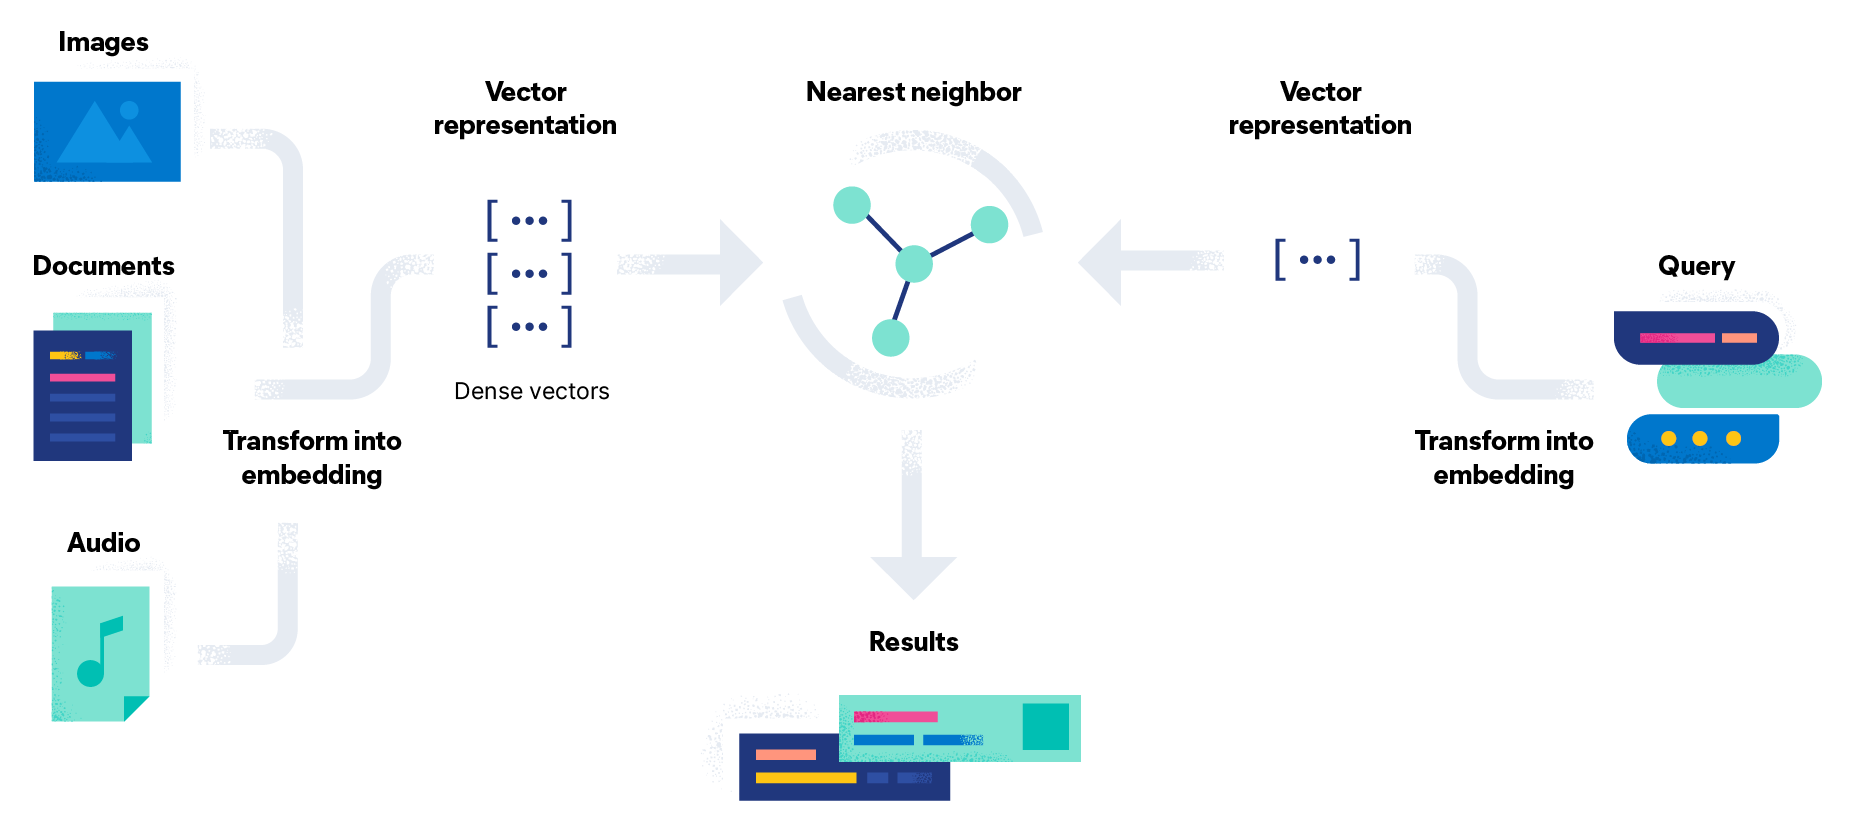

## 3.2 How to do Vectorized Search with Elasticsearch
- Let's start with the architecture of the Semantic Search system we're going to build:
```mermaid
graph LR
    documents.json -->|load| documents
    subgraph Process
        documents --> embeddings
        embeddings --> index
        index -->|store| Elasticsearch[(Elasticsearch vector DB)]
    end
    Elasticsearch -->|retrieve| Semantic_search_results(Semantic search results)
    new_search_query(New search query) -.-> embeddings
    embeddings  -.-> Elasticsearch
	
	style new_search_query stroke:blue,stroke-width:2px;
```

- The way this system works is as follows:
    - our `documents.json` file is converted into an Elasticsearch `documents` object which is then vectorized into `embeddings`
    - Those vector embeddings are the things we convert into another Elasticsearch concept called an `index`
        - We already used indexes in the previous sections
    - The `embeddings` and the `index` are what are stored in our vector database
    - And when a user passes a query, that query is first vectorized into an embedding and compared against the existing embeddings in order to produce a search result

- Let's implement this thing!

### 3.2.1 Let's start with Semantic Search

#### Step 1 - Load our documents

In [4]:
import requests

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

# write documents to a json file
import json
with open('documents.json', 'w') as f:
    json.dump(documents, f, indent=2)


`documents_raw` is a list having the course and the data corresponding to that course 

#### Step 2 - Create embeddings using pre-trained models
- We're going to use the `sentence_transformers` library to access pre-trained embedding models
    - You can learn more about that here: https://sbert.net/
- Before going into the rest of the tutorial, I asked ChatGPT to explain what this library does in simple terms. It's basically a library with various sentence embedding models you can use to create sentence embeddings with transformer-based models
- Here's an example of how it's used when wanting to compare sentence similarity:

In [6]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained model
model = SentenceTransformer('all-mpnet-base-v2')

# Encode sentences to get embeddings
sentences = ["How are you?", "What is your name?", "Hello! How do you do?"]
embeddings = model.encode(sentences)

# Compute similarity between the first sentence and the others
similarities = util.pytorch_cos_sim(embeddings[0], embeddings[1:])

print(similarities)


tensor([[0.3600, 0.6323]])


- This is computing cosine similarity betwen the first word `embeddings[0]` and the other 2 words `embeddings[1:]`
    - It's telling us the 3rd sentence is almost 2x more similar to the first sentence than the second
- Intuitively, this makes sense!
- Ok, let's forge ahead and see how we apply this to our FAQ document
    - Let's create embeddings out of the `'text'` field in the documents list

In [19]:
documents_embedding = []

for doc in documents:
    doc['text_embedding'] = model.encode(doc['text']).tolist()
    documents_embedding.append(doc)

documents_embedding[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'text_embedding': [-0.03570355847477913,
  -0.06891412287950516,
  -0.044483352452516556,
  0.0062501393258571625,
  -0.042247142642736435,
  -0.006454026326537132,
  0.02754812128841877,
  -0.018610356375575066,
  -0.052037592977285385,
  -0.0024046804755926132,
  0.057454537600278854,
  -0.015592586249113083,
  0.015488773584365845,
  0.09870164841413498,
  0.01564964279532432

#### Step 3 - Set up Elasticsearch connection

In [22]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://192.168.50.49:9200')

es_client.info()

ObjectApiResponse({'name': 'b3a351c3296c', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'OJZEGlS9RR6yoR11cShgug', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4 Create Elasticsearch mappings and index
- The mapping is some metadata telling Elasticsearch how the fields and content in the documents should be typed
    - Each document in the is a collection of fields, each having a different data type
    - And we've now added a new one, which is the embedding of the `text` field
- This is similar to setting a database schema
- We are just going to take the `index_settings` from week 1 and add the embedding
- When adding the new embeddings field to the `properties` section, we are specifying a type `dense_vector` in addition to some other parameters:
    - A `dense vector` is a type of vector used to represent data in high-dimensional space and each element of the is stored and non-zero (contrast to a sparse vector)
    - The `dims` are just the dimension of the vector which can be found by finding the length of the encoding `len(encoded_field)`
        - Different models you choose will create vectors of the varying dimensions, but the same model will create vectors of the same length
    - Specifying `index:True` just lets us efficiently store and query it
    - And lastly setting `similarities` to `cosine` will just allow us to efficiently calculate cosine similarity between different fields efficiently

In [24]:
len(documents_embedding[4]['text_embedding'])

768

In [27]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "text_embedding": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"}
        }
    }
}

index_name = "course-questions"

if es_client.indices.exists(index=index_name):
    es_client.indices.delete(index=index_name)
    print(f"Index {index_name} deleted.")
else:
    print(f"Index {index_name} does not exist.")
    es_client.indices.create(index=index_name, body=index_settings)

Index course-questions does not exist.


#### Step 5 Add documents to the index
- I'm just pulling the same code from the previous weeks to do this

In [29]:
from tqdm.auto import tqdm

## Index the documents
for doc in tqdm(documents_embedding):
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

100%|██████████| 948/948 [00:11<00:00, 84.76it/s]


#### Step 6 Create the user query
- Main thing to note here is the question we're asking isn't enough. We must also:
    - Convert the text question into an embedding: `model.encode`
    - Specify how many of the k-nearest neighbours to return back once we do a similarity calc: `k` parameter
    - Specify the total documents to consider: `num_candidates` parameter

In [30]:
question = "windows or mac?"
vector_question = model.encode(question)

query = {
    "field": "text_embedding",
    "query_vector": vector_question,
    "k": 5,
    "num_candidates": 10000,
}

#### Step 7 Perform a semantic search using Elasticsearch VectorDB

In [31]:
res= es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'Vn0ytJABBRmP4y361Shn',
  '_score': 0.71479183,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': 'aX0ytJABBRmP4y36-SuG',
  '_score': 0.61347365,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares 

### 3.2.2 Now let's try Advanced Semantic Search
- In order to do a more advanced semantic search using Elasticsearch, we can take the query from the user, encode it and then pass a few other parameters that we saw in the previous sessions
    - The way we do this is by passing the original encoded query to the `knn` parameter
    - And, passing the filter to the `query` parameter
- When doing advanced semantic search this way, the scoring mechanism isn't normalized to [0:1]. You can get scores greater than 1
    - To find out how that score is calculated, you can pass the Elasticsearch `search` method a parameter `explain = True`

In [38]:
question = "windows or mac?"
vector_question = model.encode(question)

# Pass the embedded version of the question to the Elasticsearch search function
knn_query = {
    "field": "text_embedding",
    "query_vector": vector_question,
    "k": 5,
    "num_candidates": 10000,
}

## Add a filter to the search
query = {"match": 
         {"course": "data-engineering-zoomcamp"}
         }

res = es_client.search(index=index_name, 
                       query = query,
                       knn=knn_query, 
                       source=["text", "section", "question", "course"],
                       size=3,
                       explain=True)

res["hits"]["hits"]

[{'_shard': '[course-questions][0]',
  '_node': 'lxwBTO3-R-e0G28Pi0OWpQ',
  '_index': 'course-questions',
  '_id': 'Vn0ytJABBRmP4y361Shn',
  '_score': 1.4937057,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'},
  '_explanation': {'value': 1.4937057,
   'description': 'sum of:',
   'details': [{'value': 0.71479183,
     'description': 'within top k documents',
     'details': []},
    {'value': 0.778914,
     'description': 'weight(course:data-engineering-zoomcamp in 35) [PerFieldSimilarity], result of:',
     'details': [{'value': 0.778914,
       'description': 'score(freq=1.0), computed as boost * idf * tf from:',
       'details': [{'value': 2.2, 'description': 'boost', 'details': []},
        {'value': 0.778914,
         'descripti

## 3.3 Evaluation
- Evaluating the quality of a particular RAG pipeline can be subjective
- There are many techniques you can employ to determine whether the responses you're getting are "good"
    - Often, these techniques require a "ground truth dataset"
- In the next series of exercises, we'll be exploring a few things:
    - Metrics to evaluate a RAG
    - How to create ground truth or gold standard data by which to run evaluations
        - For example, for a given query, you may have already labeled documents which are considered "correct"
        - You can run tests to ensure these documents are in the result set your RAG returns
        - You might even be able to use LLMs to generate these ground truth datasets
    - How to put them together to evaluate results based on ground truth and the metrics
- Let's go!

### 3.3.1 Evaluation metrics for retrieval
- If you think back to the different searches we've done, there are many parameters that can be tuned in order to generate different results.
- Take, for example, the `keyword search` we did with Elasticsearch, with the following search query:
```python
search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^3", "text", "section"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp"
                    }
                }
            }
        }
    }
```

- Here you can see, we can change `field` weights, we can change the `type`, we can change the `filter`
- In the advanced vector search example, we had even more things:
```python
model = SentenceTransformer('all-mpnet-base-v2')

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "text_embedding": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"}
        }
    }
}

question = "windows or mac?"
vector_question = model.encode(question)

knn_query = {
    "field": "text_embedding",
    "query_vector": vector_question,
    "k": 5,
    "num_candidates": 10000,
}

## Add a filter to the search
query = {"match": 
         {"course": "data-engineering-zoomcamp"}
         }
```

- We can change the `model` we used to encode the question, we can change the kin dof `similarity` in the index settings, etc.
- Here is a whole bunch of evaluation metrics from ChatGPT. We'll probably end up using only two of them: `Hit rate` and `MRR`:
    1. **Precision at k (P@k)**:
    - Measures the number of relevant documents in the top k results.
    - Formula: `P@k = (Number of relevant documents in top k results) / k`

    2. **Recall**:
    - Measures the number of relevant documents retrieved out of the total number of relevant documents available.
    - Formula: `Recall = (Number of relevant documents retrieved) / (Total number of relevant documents)`

    3. **Mean Average Precision (MAP)**:
    - Computes the average precision for each query and then averages these values over all queries.
    - Formula: `MAP = (1 / |Q|) * Σ (Average Precision(q))` for q in Q

    4. **Normalized Discounted Cumulative Gain (NDCG)**:
    - Measures the usefulness, or gain, of a document based on its position in the result list.
    - Formula: `NDCG = DCG / IDCG`
        - `DCG = Σ ((2^rel_i - 1) / log2(i + 1))` for i = 1 to p
        - `IDCG` is the ideal DCG, where documents are perfectly ranked by relevance.

    5. **Mean Reciprocal Rank (MRR)**:
    - Evaluates the rank position of the first relevant document.
    - Formula: `MRR = (1 / |Q|) * Σ (1 / rank_i)` for i = 1 to |Q|

    6. **F1 Score**:
    - Harmonic mean of precision and recall.
    - Formula: `F1 = 2 * (Precision * Recall) / (Precision + Recall)`

    7. **Area Under the ROC Curve (AUC-ROC)**:
    - Measures the ability of the model to distinguish between relevant and non-relevant documents.
    - AUC is the area under the Receiver Operating Characteristic (ROC) curve, which plots true positive rate (TPR) against false positive rate (FPR).

    8. **Mean Rank (MR)**:
    - The average rank of the first relevant document across all queries.
    - Lower values indicate better performance.

    9. **Hit Rate (HR) or Recall at k**:
    - Measures the proportion of queries for which at least one relevant document is retrieved in the top k results.
    - Formula: `HR@k = (Number of queries with at least one relevant document in top k) / |Q|`

    10. **Expected Reciprocal Rank (ERR)**:
        - Measures the probability that a user finds a relevant document at each position in the ranked list, assuming a cascading model of user behavior.
        - Formula: `ERR = Σ (1 / i) * Π (1 - r_j) * r_i` for j = 1 to i-1
        - Where `r_i` is the relevance probability of the document at position i.

### 3.3.2 Ground truth generation for retrieval evaluation

### 3.3.3 Evaluation of text retrieval techniques for RAG

### 3.3.4 Evaluation vector retrieval